In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import PIL.Image
from datetime import datetime
import PIL.ExifTags
from tqdm import tqdm


import dateutil.parser
import os
import re

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, MaxNLocator)

from pyphasechip import pyphasechip_logic as pypc
from typing import Tuple

## Variables

In [2]:
# reagent 1 name
name_sol1 = "BSA"
# reagent 1 starting contentration
initial_conc_sol1 = 2800
# unit
unit_sol1 = "µM"


# reagent 2 name
name_sol2 = "PEG"
# reagent 2 starting concentration
initial_conc_sol2 = 13
# unit
unit_sol2 = "%"


# mixing ratio of the concentrations 0
# [1:X]
initial_ratio = 7


# Number of different concentrations used
number_of_diff_conc = 5

# Number of wells
n_wells = 9

# total amount of images
total_n_images = 2475
n_timepoints = int(total_n_images / (number_of_diff_conc * n_wells)) 

# threshold for LLPS detection, some kind of sensitivity value
# if LLPS is detected not at all or too late, raise value by 10 or 20
# 130 is default, range: 0-255
# BSA-Test set: 175
thresh_llps = 130

#####################################################################################

# percental difference of img mean to all previous imgages. 
# usually this works
percental_threshold = 2400

# measured diameter of chamber to calculate radii for circle detection -> min and max [px]
# around +-30 of the real value, best measured with something like imageJ/Fiji
diameter = 238 
minRadiusChamber = int((diameter/2)*0.7)
maxRadiusChamber = int((diameter/2)*1.3)


# height of chamber [µm]
chamber_height = 60

# folder where images are stored
# best is to use only paths without any whitespace
image_folder = r"C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\20220701_tsf_NaCl_subset"
#image_folder = r"C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\20220702_tsf_PEG_subset"
#image_folder = r"C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\20220601_BSA_PEG_FC40_subset"
#image_folder = r"C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\images_for_thesis"

# datatype of the images
extension = ".jpg"

# TODO: use a .yml file for storing these variables

In [ ]:
#THIS IS FOR CELLOBSERVER/ZEISS IMAGES ONLY

def get_sorted_file_list(image_folder: str) -> list:
    files, times, concs, wells = [], [], [], []
    
    for file in os.listdir(image_folder):
        # 1. More robust, faster, but more specific
        c, w, _, t = re.search("c(\d+)_w(\d+)_s(\d+)t(\d+)", file).groups()

        # 2. Other way
        #c, w, _, t, *params = re.findall('[0-9]+', file)
        
        # Generate lists
        times.append(int(t))
        concs.append(int(c))
        wells.append(int(w))
        files.append(file)
        
    return [x for _, _, _, x in sorted(zip(concs, times, wells, files))]
    
get_sorted_file_list(image_folder)

## Starting concentrations

In [3]:
# Two possibilities:
# use script if you did a pipetting series
starting_concentrations = pypc.starting_concentration(initial_conc_sol1, initial_conc_sol2, initial_ratio)
# or
# write list
#starting_concentrations = np.array(([40, 9.5], [100, 7.2], [530, 4], [2800, 1.7]))  # BSA Test set
starting_concentrations = np.array(([9.4, 88.6], [21.2, 74.3], [33.0, 60.0], [44.8, 45.7], [56.6, 31.4]))

## Programm

In [4]:
# Create all the necessary dicts and lists
image_list, image_names, data_well, well, concentration, time_resolution = pypc.create()

# Load images & convert to grayscale
print("Write images into list")
pypc.images_to_list(image_list, image_names, image_folder, extension)
print("Save them into a dictionary")
pypc.images_to_dict(n_timepoints, number_of_diff_conc, n_wells, image_list, image_names, time_resolution, concentration, well, data_well)

print("Analyse data...")
well_nr = 0
for conc_nr in range(number_of_diff_conc): # for n_rows_per_conc in range(2):
    
    for n_wells_per_row in range(n_wells):

        # Initialise variables, arrays and lists
        well_data = np.zeros(shape=(2, 3))
        threshed_img = np.zeros(shape=time_resolution[0][0][0]['gray'].shape, dtype="uint8")
        areas = np.zeros(shape=(1, 2))
        droplet_arr = np.zeros(shape=(2,4))
        mean_list = []
        llps_status = False
        n_0 = 0
        multiple_droplets = None
        multiple_droplets_count = 0
        areas_list = []

        print("conc:", conc_nr, "well:", well_nr)
        for time_idx in tqdm(range(n_timepoints)): #n_timepoints
            if llps_status is False:
                #print("---", "C:", conc_nr, "W:", well_nr, " T:", time_idx, "---")

                image = time_resolution[time_idx][conc_nr][well_nr]['gray'].copy()

                x, y, r, droplet_data, droplet_found, multiple_droplets_count, masked_img, grad2, well_data, grad1 = pypc.droplet_detection(image, well_data, diameter, llps_status,
                                                                                                                                     multiple_droplets_count, droplet_arr, time_idx, conc_nr, well_nr)

                time_resolution[time_idx][conc_nr][well_nr]['img'] = masked_img
                time_resolution[time_idx][conc_nr][well_nr]['grad2'] = grad2
                time_resolution[time_idx][conc_nr][well_nr]['grad1'] = grad1 # needed for display
                time_resolution[time_idx][conc_nr][well_nr]['droplet data'] = droplet_arr.copy()
                time_resolution[time_idx][conc_nr][well_nr]['x'] = x # needed for display
                time_resolution[time_idx][conc_nr][well_nr]['y'] = y # needed for display
                time_resolution[time_idx][conc_nr][well_nr]['r'] = well_data[0, 2] # needed for display
                time_resolution[0][conc_nr][well_nr]['multiple droplets'] = multiple_droplets_count

                # save first area
                if time_idx == 0:
                    areas[0, 0] = droplet_arr[0, 3]

                llps_status, areas, areas_list, mean_list, droplet_arr, squi, cro_squi, n_0, thresh = pypc.detect_LLPS(percental_threshold, droplet_arr, llps_status, image, time_idx, areas, areas_list, mean_list, droplet_found, n_0, thresh_llps)
                                                                                                                                                # masked_img
                # if noise is too high, ignore droplet
                # later: change "multiplet droplets" to "ignore well"
                if n_0 > 400:
                    multiple_droplets = True
                    time_resolution[0][conc_nr][well_nr]['multiple droplets'] = multiple_droplets


                time_resolution[0][conc_nr][well_nr]['areas'] = areas
                time_resolution[0][conc_nr][well_nr]['mean list'] = mean_list
                time_resolution[time_idx][conc_nr][well_nr]['squ'] = squi
                time_resolution[time_idx][conc_nr][well_nr]['cro squ'] = cro_squi
                time_resolution[time_idx][conc_nr][well_nr]['cro squ thresh'] = thresh

                time_resolution[time_idx][conc_nr][well_nr]['droplet array'] = droplet_arr


                if llps_status is True:
                    print("LLPS status: ", llps_status, ", @", "c:", conc_nr, "w:", well_nr, "t:", time_idx)
                    # save img time where llps was found
                    time_resolution[0][conc_nr][well_nr]['time idx'] = time_idx
                    # save name of image where LLPS was detected
                    time_resolution[0][conc_nr][well_nr]['LLPS name'] = time_resolution[time_idx][conc_nr][well_nr]['name']
                    # calculate the critical concentration
                    llps_conc = pypc.ccrit_calculation(starting_concentrations, areas, conc_nr)
                    time_resolution[0][conc_nr][well_nr]['LLPS conc'] = llps_conc
                    time_resolution[0][conc_nr][well_nr]['areas_list'] = areas_list

        well_nr += 1
    well_nr = 0

Write images into list


100%|█████████████████████████████████████████████████████████████████████████████| 2480/2480 [00:18<00:00, 135.59it/s]


Save them into a dictionary


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

Analyse data...
conc: 0 well: 0


 87%|███████████████████████████████████████████████████████████████████████▌          | 48/55 [00:36<00:05,  1.35it/s]C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\pythonProject\PyPhaseChip\pyphasechip\pyphasechip_fun.py:279: RuntimeWarning: divide by zero encountered in double_scalars
  percental_difference = (mean_abs / avg_mean_all_previous_images) * 100 - 100
  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 0 w: 0 t: 48
conc: 0 well: 1


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 0 w: 1 t: 47
conc: 0 well: 2


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 0 w: 2 t: 42
conc: 0 well: 3


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 0 w: 3 t: 44
conc: 0 well: 4


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 0 w: 4 t: 43
conc: 0 well: 5


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 0 w: 5 t: 41
conc: 0 well: 6


 11%|█████████                                                                          | 6/55 [00:04<00:40,  1.22it/s]C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\pythonProject\PyPhaseChip\pyphasechip\pyphasechip_fun.py:300: RuntimeWarning: invalid value encountered in double_scalars
  m = (areas_list[p-3][0] - areas_list[q][0]) / (areas_list[p-3][1] - areas_list[q][1])
  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 0 w: 6 t: 6
conc: 0 well: 7


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 0 w: 7 t: 40
conc: 0 well: 8


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 0 w: 8 t: 41
conc: 1 well: 0


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 1 w: 0 t: 7
conc: 1 well: 1


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 1 w: 1 t: 41
conc: 1 well: 2


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 1 w: 2 t: 40
conc: 1 well: 3


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 1 w: 3 t: 44
conc: 1 well: 4


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 1 w: 4 t: 43
conc: 1 well: 5


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 1 w: 5 t: 43
conc: 1 well: 6


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 1 w: 6 t: 38
conc: 1 well: 7


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 1 w: 7 t: 41
conc: 1 well: 8


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 1 w: 8 t: 37
conc: 2 well: 0


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 2 w: 0 t: 14
conc: 2 well: 1


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 2 w: 1 t: 38
conc: 2 well: 2


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 2 w: 2 t: 38
conc: 2 well: 3


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 2 w: 3 t: 37
conc: 2 well: 4


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 2 w: 4 t: 37
conc: 2 well: 5


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 2 w: 5 t: 36
conc: 2 well: 6


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 2 w: 6 t: 36
conc: 2 well: 7


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 2 w: 7 t: 36
conc: 2 well: 8


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 2 w: 8 t: 35
conc: 3 well: 0


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 3 w: 0 t: 33
conc: 3 well: 1


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 3 w: 1 t: 33
conc: 3 well: 2


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 3 w: 2 t: 33
conc: 3 well: 3


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 3 w: 3 t: 33
conc: 3 well: 4


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 3 w: 4 t: 33
conc: 3 well: 5


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 3 w: 5 t: 47
conc: 3 well: 6


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 3 w: 6 t: 33
conc: 3 well: 7


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 3 w: 7 t: 34
conc: 3 well: 8


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 3 w: 8 t: 34
conc: 4 well: 0


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 4 w: 0 t: 19
conc: 4 well: 1


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 4 w: 1 t: 29
conc: 4 well: 2


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 4 w: 2 t: 31
conc: 4 well: 3


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

conc: 4 well: 4


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 4 w: 4 t: 28
conc: 4 well: 5


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 4 w: 5 t: 30
conc: 4 well: 6


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 4 w: 6 t: 29
conc: 4 well: 7


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

LLPS status:  True , @ c: 4 w: 7 t: 29
conc: 4 well: 8


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:22<00:00,  2.42it/s]

LLPS status:  True , @ c: 4 w: 8 t: 29


In [ ]:
# saves the image names where LLPS was detected and the calculated concentrations to a csv file
# .csv gets safed in the image folder
pypc.save_results_to_csv(time_resolution, image_folder, number_of_diff_conc, n_wells, name_sol1, name_sol2, unit_sol1, unit_sol2, thresh_llps)

## quality control

In [ ]:
for c in range(0, number_of_diff_conc):
    for w in range(0, n_wells):
        if 'time idx' in time_resolution[0][c][w]:
            print(c, w, ":", "time idx:", time_resolution[0][c][w]['time idx'], time_resolution[0][c][w]['LLPS name'])
        #elif time_resolution[0][c][w]['multiple droplets'] > 3:
        #    print(c, w, ":", "multiple droplets")
        else:
            print(c, w, ":", "no LLPS")

meanlist [4.951456310679611, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1020.0] ; mean: 36.60540915395284
Areas: [[37994.     5317.904]]
starting conc: [56.6 31.4]


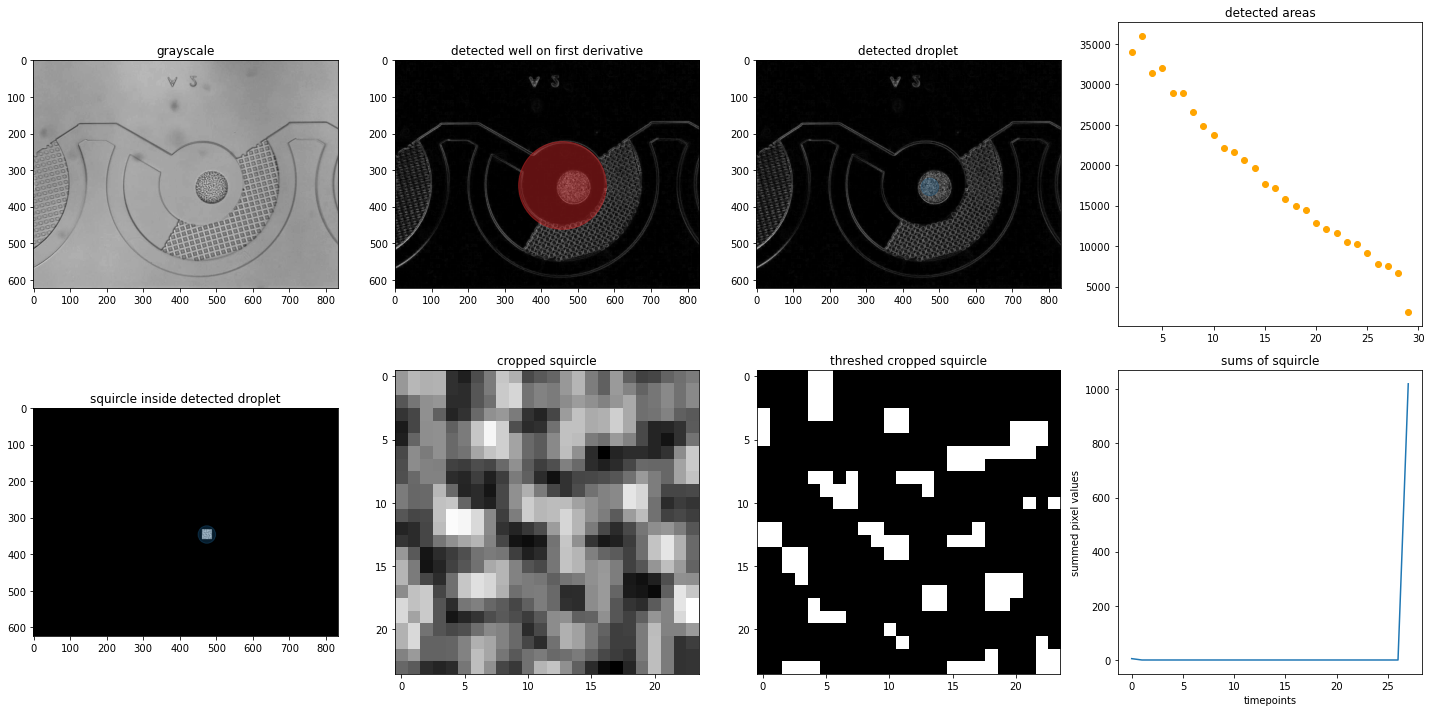

In [5]:
c = 4
w = 7
t = 29

image = time_resolution[t][c][w]['gray'].copy()
img  = time_resolution[t][c][w]['img'].copy() # masked img
grad  = time_resolution[t][c][w]['grad2'].copy()
xd = time_resolution[t][c][w]['droplet data'][0,0]
yd = time_resolution[t][c][w]['droplet data'][0,1]
rd = time_resolution[t][c][w]['droplet data'][0,2]
xw = time_resolution[t][c][w]['x']
yw = time_resolution[t][c][w]['y']
rw = time_resolution[t][c][w]['r']

print("meanlist", time_resolution[0][c][w]['mean list'], "; mean:", np.mean(time_resolution[0][c][w]['mean list']))
print("Areas:", time_resolution[0][c][w]['areas'])
print("starting conc:", starting_concentrations[c])
#print("LLPS conc:", time_resolution[0][c][w]['LLPS conc'])

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

axs[0, 0].imshow(image, cmap="gray")
axs[0,0 ].set_title("grayscale")

axs[0, 1].imshow(time_resolution[t][c][w]['grad1'], cmap="gray")
axs[0, 1].set_title("detected well on first derivative")
circle = plt.Circle((xw, yw), rw, color='tab:red', alpha=0.45)
axs[0, 1].add_patch(circle)

#axs[0, 2].imshow(img, cmap="gray")
#axs[0, 2].set_title("masked first derivative")

axs[1, 2].imshow(time_resolution[t][c][w]['cro squ thresh'], cmap="gray")
axs[1, 2].set_title("threshed cropped squircle")

axs[0, 2].imshow(time_resolution[t][c][w]['grad1'], cmap="gray")
axs[0, 2].set_title("detected droplet")
circle = plt.Circle((xd, yd), rd, color='tab:blue', alpha=0.25)
axs[0, 2].add_patch(circle)

axs[1, 0].imshow(time_resolution[t][c][w]['squ'], cmap="gray")
axs[1, 0].set_title("squircle inside detected droplet")
circle = plt.Circle((xd, yd), rd, color='tab:blue', alpha=0.25)
axs[1, 0].add_patch(circle)

axs[1, 1].imshow(time_resolution[t][c][w]['cro squ'], cmap="gray")
axs[1, 1].set_title("cropped squircle")

x = []
y = []
for i in range(len(time_resolution[0][c][w]['areas_list'])):
    x.append(time_resolution[0][c][w]['areas_list'][i][1])
    y.append(time_resolution[0][c][w]['areas_list'][i][0])
axs[0, 3].scatter(x, y, color='orange')
axs[0, 3].set_title("detected areas")

axs[1, 3].set_title("sums of squircle")
axs[1, 3].set_xlabel("timepoints")
axs[1, 3].set_ylabel("summed pixel values")
axs[1, 3].plot(np.arange(len(time_resolution[0][c][w]['mean list'])), time_resolution[0][c][w]['mean list'])
#axs[1, 3].scatter(t, time_resolution[0][c][w]['mean list'][len(time_resolution[0][c][w]['mean list'])], color='red')


plt.style.use("default")
fig.tight_layout() #otherwise fig will be clipped
filenamesvg = f'c{c}_w{w}_t{t}_method.svg'
plt.savefig(image_folder + '/' + filenamesvg, bbox_inches="tight")

## Plot the data

In [ ]:
### figure setup ###


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,8), sharex=False, sharey=False)

# set labels
ax1.set_xlabel(f"{name_sol1} [{unit_sol1}]")
ax1.set_ylabel(f"{name_sol2} [{unit_sol2}]")
ax1.xaxis.label.set_size(15)
ax1.yaxis.label.set_size(15)

ax2.set_xlabel(ax1.get_xlabel())
ax2.xaxis.label.set_size(ax1.xaxis.label.get_size())
ax2.set_ylabel(ax1.get_ylabel())
ax2.yaxis.label.set_size(ax1.yaxis.label.get_size())

# set limits 
xlim = int(initial_conc_sol1 * 80)
ylim = int(initial_conc_sol2 * 80)
ax1.set_xlim(0, xlim)
ax1.set_ylim(0, ylim)
ax2.set_xlim(0, xlim)
ax2.set_ylim(0, ylim)

#ticks
x_axis_ticks_division = 1000
x_n_minor_ticks = 5
y_axis_ticks_division = 1000
y_n_minor_ticks = 5

# set titles
ax1.set_title('individual wells', fontsize=25)
ax2.set_title('means', fontsize= 25)

# set ticks
ax1.tick_params(axis='y', which='major', right=True, color="black", labelcolor="black", direction='out', labelsize=15)
ax1.tick_params(axis='y', which='minor', right=True)
ax1.tick_params(axis='x', which='major', top=True, labeltop=False, direction='out', labelsize=15)
ax1.tick_params(axis='x', which='minor', bottom=True, top=True)
ax1.minorticks_on()
ax1.xaxis.set_major_locator(MultipleLocator(x_axis_ticks_division))
ax1.xaxis.set_minor_locator(AutoMinorLocator(x_n_minor_ticks))
ax1.yaxis.set_major_locator(MultipleLocator(y_axis_ticks_division ))
ax1.yaxis.set_minor_locator(AutoMinorLocator(y_n_minor_ticks))
ax1.xaxis.set_tick_params(which='both', width=2)
ax1.yaxis.set_tick_params(which='both', width=2)


ax2.tick_params(axis='y', which='major', right=True, color="black", labelcolor="black", direction='out', labelsize=15)
ax2.tick_params(axis='y', which='minor', right=True)
ax2.tick_params(axis='x', which='major', top=True, labeltop=False, direction='out', labelsize=15)
ax2.tick_params(axis='x', which='minor', bottom=True, top=True)
ax2.minorticks_on()
ax2.xaxis.set_major_locator(MultipleLocator(x_axis_ticks_division))
ax2.xaxis.set_minor_locator(AutoMinorLocator(x_n_minor_ticks))
ax2.yaxis.set_major_locator(MultipleLocator(y_axis_ticks_division ))
ax2.yaxis.set_minor_locator(AutoMinorLocator(y_n_minor_ticks))
ax2.xaxis.set_tick_params(which='both', width=2)
ax2.yaxis.set_tick_params(which='both', width=2)


# plot starting concentrations and the data
well_nr = 0

for conc_nr in range (number_of_diff_conc):
        for n_wells_per_horizontal in range(n_wells):
            if time_resolution[0][conc_nr][well_nr]['areas'][0, 1] != 0:
            
                if conc_nr == 0:
                    color = "blue"
                if conc_nr == 1:
                    color = "orange"
                if conc_nr == 2:
                    color = "gray"
                if conc_nr == 3:
                    color = "yellow"
                if conc_nr == 4:
                    color = "green"

                ax1.scatter(starting_concentrations[conc_nr,0], starting_concentrations[conc_nr,1], s=60, c=color, marker="s", edgecolors="black")
                ax1.scatter(time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,0],time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,1],
                            s=60, color=color, marker="o", edgecolors="black")
                
            well_nr += 1
        well_nr = 0
well_nr = 0


# calculate and plot mean
mean_sol1 = []
mean_sol1 = [0] * 5
mean_sol2 = []
mean_sol2 = [0] * 5
n_llps_wells = []
n_llps_wells = [0] * 5

for conc_nr in range (number_of_diff_conc):
        for n_wells_per_horizontal in range(n_wells):
            if time_resolution[0][conc_nr][well_nr]['areas'][0, 1] != 0:   
                # calculate mean
                mean_sol1[conc_nr] = mean_sol1[conc_nr] + time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,0]
                mean_sol2[conc_nr] = mean_sol2[conc_nr] + time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,1]
                n_llps_wells[conc_nr] += 1
                
            well_nr += 1
        well_nr = 0
well_nr = 0


for conc_nr in range(number_of_diff_conc):
    if conc_nr == 0:
        color = "blue"
    if conc_nr == 1:
        color = "orange"
    if conc_nr == 2:
        color = "gray"
    if conc_nr == 3:
        color = "yellow"
    if conc_nr == 4:
        color = "green"
    if n_llps_wells[conc_nr] > 0:
        mean_sol1[conc_nr] = mean_sol1[conc_nr]/n_llps_wells[conc_nr]
        mean_sol2[conc_nr] = mean_sol2[conc_nr]/n_llps_wells[conc_nr]
        m = mean_sol2[conc_nr]/mean_sol1[conc_nr]
        
    ax2.plot([0, mean_sol1[conc_nr],xlim], [0, mean_sol2[conc_nr], m*xlim], color=color, linestyle='dashed', alpha=0.50)
    ax2.scatter(starting_concentrations[conc_nr,0], starting_concentrations[conc_nr,1], s=60, c=color, marker="s", edgecolors="black")

    ax2.scatter(mean_sol1[conc_nr],mean_sol2[conc_nr], s=60, color=color,
                           marker="o", edgecolors="black")

    
#pathtocsv = os.path.join(image_folder, "csv")
plt.style.use("default")
fig.tight_layout() #otherwise fig will be clipped
plt.savefig(image_folder + '/results.svg', bbox_inches="tight")